In [1]:
%load_ext autoreload
%autoreload 2

from spectrum import Spectrum
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from atomic_lines import NA_I_LINES, K_I_LINES, AtomicLine


Reading data for target HD185859: 100%|██████████| 166/166 [00:00<00:00, 8008.91it/s]


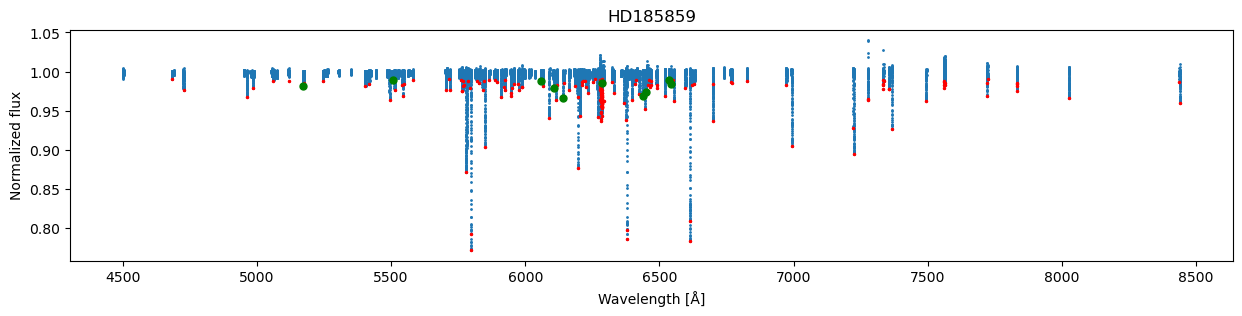

In [2]:
hd185859 = Spectrum('HD185859')
peak_indices, _ = find_peaks(-hd185859.flux, height=-0.99, prominence=0.01)

peak_diff_wvlen = np.diff(hd185859.wavelength[peak_indices], append=hd185859.wavelength[-1])
possible_na_peaks_indices = peak_indices[np.abs(peak_diff_wvlen - (NA_I_LINES[1][1] - NA_I_LINES[0][1])) < 1]

spectrum_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,3))
hd185859.plot(ax)
ax.plot(hd185859.wavelength[peak_indices], hd185859.flux[peak_indices], '.', ms=3, color='red')
ax.plot(hd185859.wavelength[possible_na_peaks_indices], hd185859.flux[possible_na_peaks_indices], '.', ms=10, color='green')
# ax.set_xlim(6277, 6290)
# ax.set_xlim(5800, 6000)

In [4]:
def identify_atomic_line(spectrum: Spectrum, line1: AtomicLine, line2: AtomicLine, search_window=(10, 100), tollerance=1):
    wvl1, wvl2 = line1[1], line2[1]
    min_wvl = np.min([wvl1, wvl2])
    max_wvl = np.max([wvl1, wvl2])
    expected_wvl_diff = max_wvl - min_wvl

    wvl_range_mask = (spectrum.wavelength > min_wvl - search_window[0]) & (spectrum.wavelength < max_wvl + search_window[1])
    wavelength = spectrum.wavelength[wvl_range_mask]
    flux = spectrum.flux[wvl_range_mask]
    peaks, _ = find_peaks(-flux, height=-0.99, prominence=0.01)

    possible_peak_combinations = []
    for current_peak in peaks:
        following_peaks = peaks[peaks > current_peak]
        wvl_diffs = wavelength[following_peaks] - wavelength[current_peak]
        possible_diff_indices = following_peaks[np.abs(wvl_diffs - expected_wvl_diff) < tollerance]

        if len(possible_diff_indices) > 0:
            possible_peak_combinations.extend(np.column_stack((wavelength[possible_diff_indices], np.full(possible_diff_indices.shape, wavelength[current_peak]))))

    return np.array(possible_peak_combinations)

def find_optimal_tollerance(spectrum: Spectrum, line1: AtomicLine, line2: AtomicLine, search_window=(10, 100), stepsize=0.001, verbose=False):
    tollerance = 0
    identified_lines = []
    while len(identified_lines) != 1:
        identified_lines.extend(identify_atomic_line(spectrum, line1, line2, search_window, tollerance))
        n_lines = len(identified_lines)

        if n_lines == 1:
            break
        elif len(identified_lines) > 1:
            if tollerance == 0:
                break
            
            tollerance -= stepsize
        else:
            tollerance += stepsize

        if verbose:
            print(f'Found {len(identified_lines)} lines, adjusting tollerance to {tollerance}')
    return tollerance


In [ ]:
def plot_atomic_lines(spectrum: Spectrum, line1: AtomicLine, line2: AtomicLine, search_window=(10, 100), tollerance=None):
    if tollerance == None:
        tollerance = find_optimal_tollerance(spectrum, line1, line2, search_window)
        print(f'Optimal tollerance {tollerance:4g}')

    identified_peaks = identify_atomic_line(spectrum, line1, line2, search_window, tollerance)
    peaks_mask = np.isin(spectrum.wavelength, identified_peaks.flatten())
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,6))

    # Show search window
    axes[0].axvline(line1[1] - search_window[0], color='black')
    axes[0].axvline(line2[1] + search_window[1], color='black')
    axes[1].set_xlim(line1[1] - search_window[0], line2[1] + search_window[1])

    for ax in axes:
        spectrum.plot(ax)
        
        # Identified peaks
        ax.plot(spectrum.wavelength[peaks_mask], spectrum.flux[peaks_mask], '.', ms=10, color='green')

        # Expected lines
        ax.axvline(line1[1], linestyle='--', color='orange', label=fr'{line1[0]}: $\lambda=${line1[1]} Å')
        ax.axvline(line2[1], linestyle='--', color='red', label=fr'{line2[0]}: $\lambda=${line2[1]} Å')


    axes[1].legend()
    fig.tight_layout()


Optimal tollerance 0.002


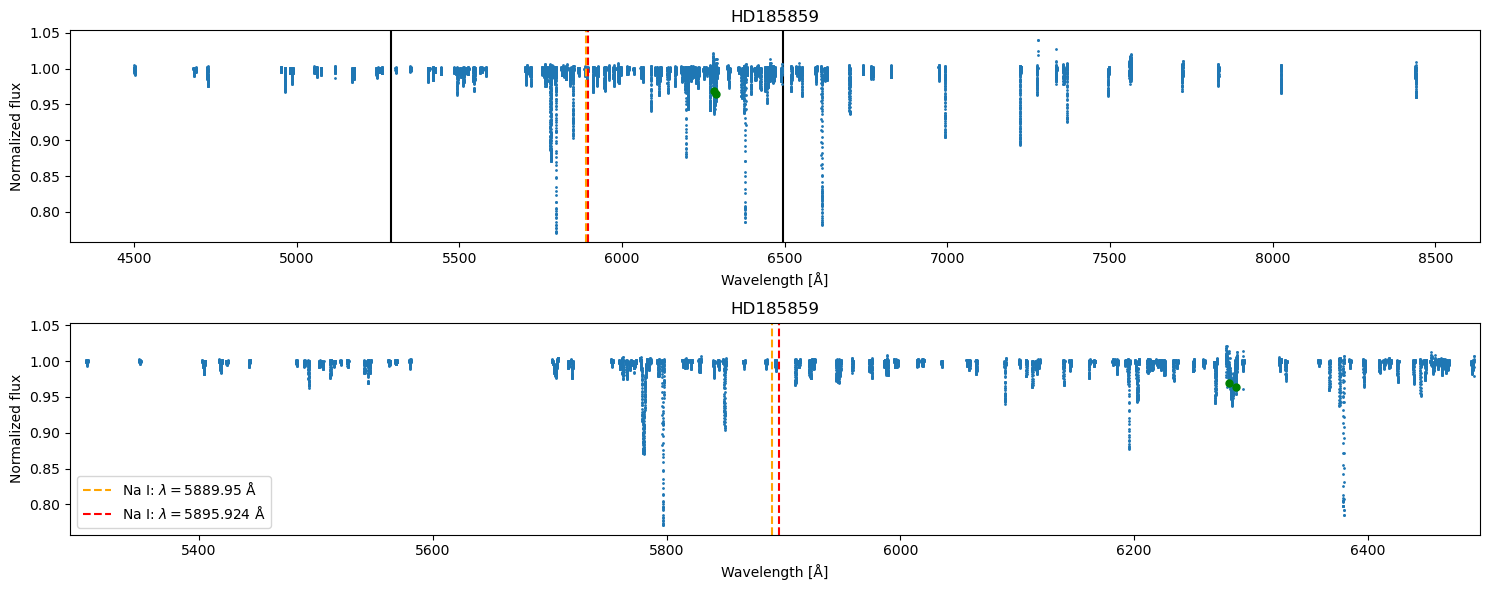

In [19]:
plot_atomic_lines(hd185859, NA_I_LINES[0], NA_I_LINES[1], (600, 600))

Optimal tollerance 0.504


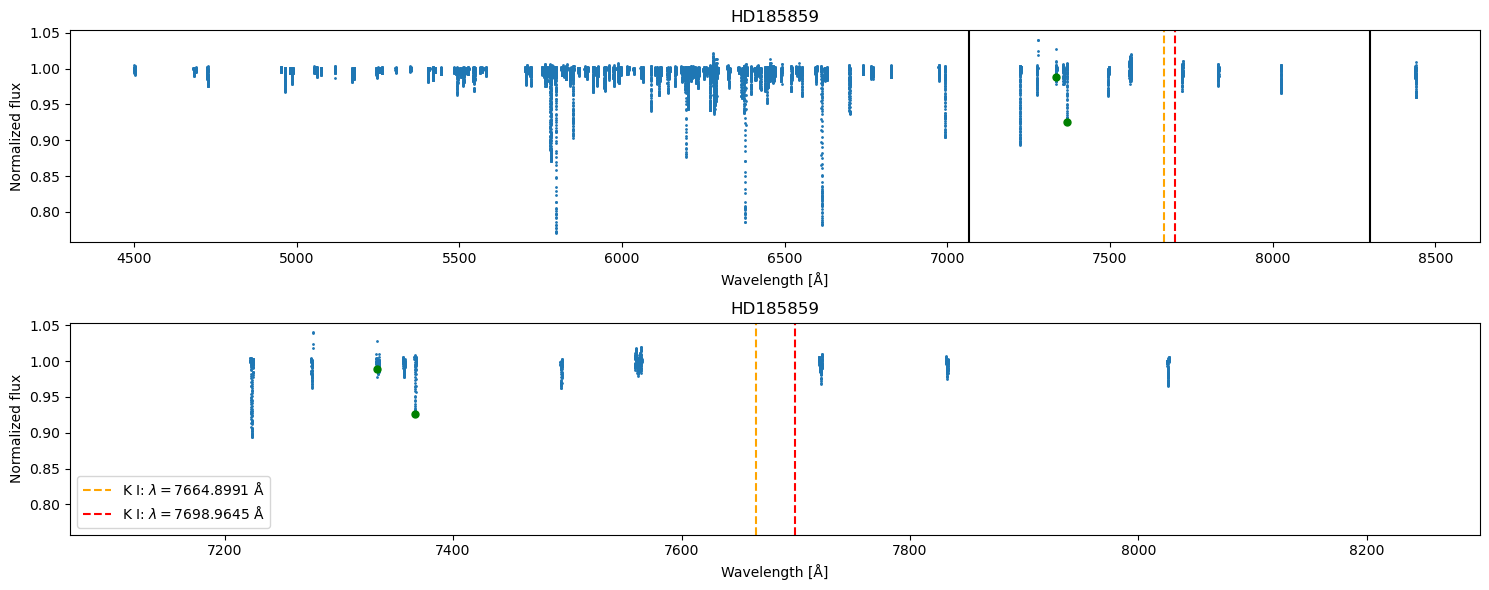

In [18]:
plot_atomic_lines(hd185859, K_I_LINES[0], K_I_LINES[1], (600, 600))